In [4]:
import sys
sys.path.append("..")
import torch
from torch import nn
from torchvision import transforms
from dataloaders.FashionMnist import load_FashionMnist
from tools.model_trainer import train_model
from tools.model_tester import test_model
from torchsummary import summary

In [3]:
batch_size = 256
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])
train_iter, _, test_iter = load_FashionMnist(batch_size=batch_size, transform=transform)
print(f"train size: {len(train_iter.dataset)}")
# print(f"valid size: {len(valid_iter.dataset)}")
print(f"test size: {len(test_iter.dataset)}")

for X, y in test_iter:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

D:\Anaconda3\envs\lxh_torch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


train size: 60000
test size: 10000
Shape of X [N, C, H, W]: torch.Size([256, 1, 28, 28])
Shape of y: torch.Size([256]) torch.int64


# Sigmoid激活函数+Xavier初始化

In [4]:
print(f"Using {device} device")
# Define model
class LeNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super(LeNet, self).__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.sigmoid1 =  nn.Sigmoid()
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.sigmoid2 =  nn.Sigmoid()
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten= nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.sigmoid3=  nn.Sigmoid()
        self.fc2 = nn.Linear(120, 84)
        self.sigmoid4 = nn.Sigmoid()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.sigmoid1(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.sigmoid2(x)
        x = self.avgpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.sigmoid3(x)
        x = self.fc2(x)
        x = self.sigmoid4(x)
        x = self.fc3(x)
        return x

net =  LeNet()

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

Using cuda device


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (sigmoid1): Sigmoid()
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (sigmoid2): Sigmoid()
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (sigmoid3): Sigmoid()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (sigmoid4): Sigmoid()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
net.to(device)
summary(net, input_size=(1, 28, 28), batch_size=32, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 6, 28, 28]             156
           Sigmoid-2            [32, 6, 28, 28]               0
         AvgPool2d-3            [32, 6, 14, 14]               0
            Conv2d-4           [32, 16, 10, 10]           2,416
           Sigmoid-5           [32, 16, 10, 10]               0
         AvgPool2d-6             [32, 16, 5, 5]               0
           Flatten-7                  [32, 400]               0
            Linear-8                  [32, 120]          48,120
           Sigmoid-9                  [32, 120]               0
           Linear-10                   [32, 84]          10,164
          Sigmoid-11                   [32, 84]               0
           Linear-12                   [32, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

Train result
loss 0.457
final train Accuracy 0.831
final valid Accuracy 0.827
6017.818 examples/sec on cuda
9.954 sec/epoch on cuda


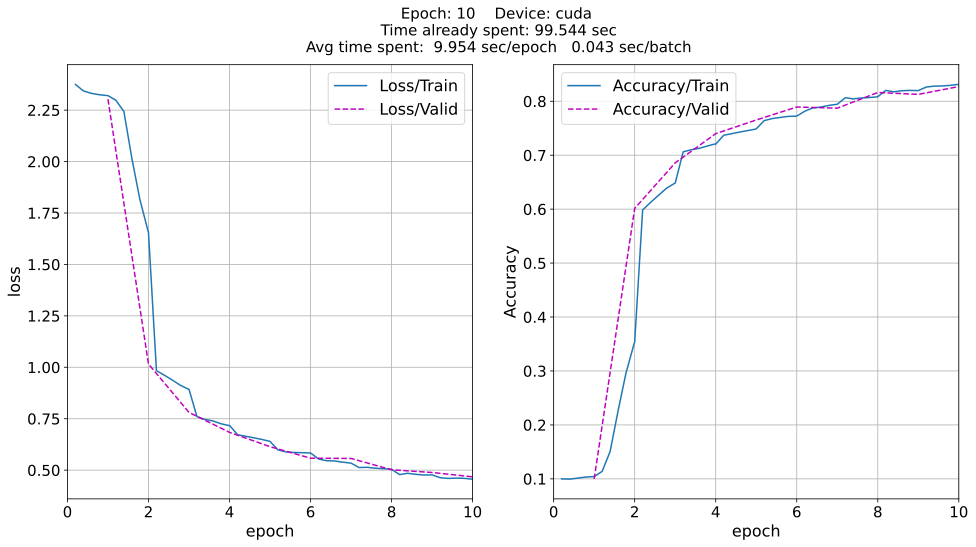

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.9)
train_model(net, train_iter, test_iter, loss_fn, ['accuracy'], optimizer, num_epochs=10, device=device, use_tensorboard=True, use_animator=True, comment='_LeNet_sigmoid_xavier') 


In [13]:
test_model(net, test_iter, loss_fn, ['accuracy'], device=device)

        Test result
            Number of instances: 10000
            Number of batches: 39
            Avg loss of each batch: 0.467452
            
Accuracy: 0.827
Time spent: 0.20880746841430664 sec
                47891.007 examples/sec
                0.005 sec/batch on cuda
                


(0.4674522273051433, [0.8273])

# Sigmoid函数+默认初始化

In [14]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (sigmoid1): Sigmoid()
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (sigmoid2): Sigmoid()
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (sigmoid3): Sigmoid()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (sigmoid4): Sigmoid()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Train result
loss 0.964
final train Accuracy 0.611
final valid Accuracy 0.655
9978.855 examples/sec on cuda
6.003 sec/epoch on cuda


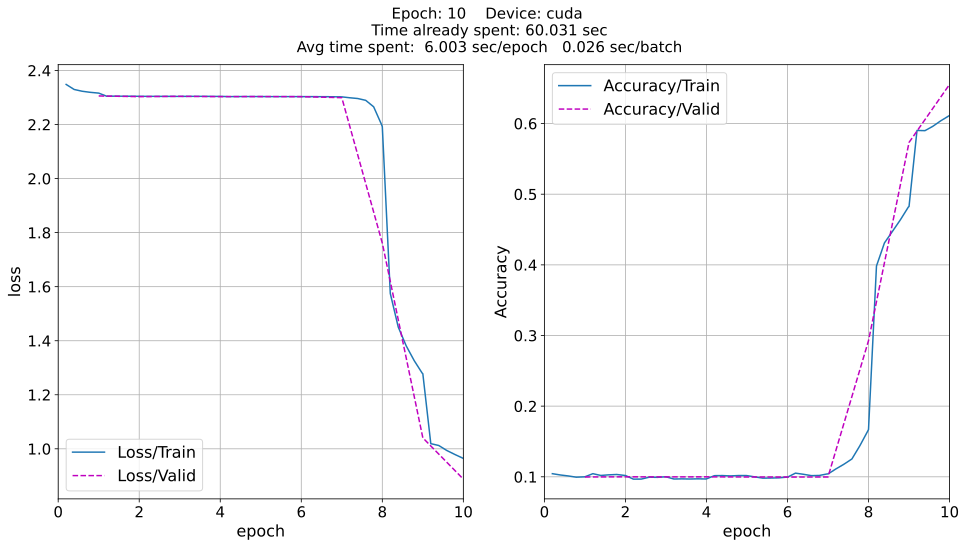

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.9)
train_model(net, train_iter, test_iter, loss_fn, ['accuracy'], optimizer, num_epochs=10, device=device, use_tensorboard=True, use_animator=True, comment='_LeNet_sigmoid_default') 

In [16]:
test_model(net, test_iter, loss_fn, ['accuracy'], device=device)

        Test result
            Number of instances: 10000
            Number of batches: 39
            Avg loss of each batch: 0.887762
            
Accuracy: 0.655
Time spent: 0.1966252326965332 sec
                50858.172 examples/sec
                0.005 sec/batch on cuda
                


(0.8877617365274674, [0.6553])

# ReLU函数+Xavier初始化

In [17]:
class LeNet_ReLU(nn.Module):
    def __init__(self, *args, **kwargs):
        super(LeNet_ReLU, self).__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.relu1 =  nn.ReLU()
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 =  nn.ReLU()
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten= nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3=  nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avgpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x

net = LeNet_ReLU()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

LeNet_ReLU(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Train result
loss 2.304
final train Accuracy 0.099
final valid Accuracy 0.100
8916.758 examples/sec on cuda
6.718 sec/epoch on cuda


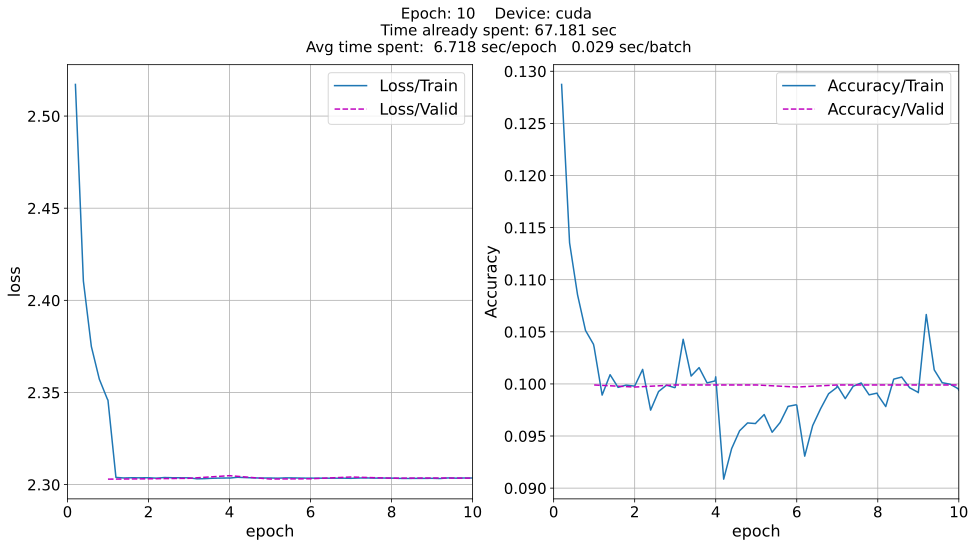

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.9)
train_model(net, train_iter, test_iter, loss_fn, ['accuracy'], optimizer, num_epochs=10, device=device, use_tensorboard=True, use_animator=True, comment='_LeNet_relu_xavier') 

In [19]:
test_model(net, test_iter, loss_fn, ['accuracy'], device=device)


        Test result
            Number of instances: 10000
            Number of batches: 39
            Avg loss of each batch: 2.303520
            
Accuracy: 0.100
Time spent: 0.4842987060546875 sec
                20648.414 examples/sec
                0.012 sec/batch on cuda
                


(2.303520251543094, [0.0999])

# ReLU函数+默认初始化

In [20]:
net = LeNet_ReLU()
print(net)

LeNet_ReLU(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Train result
loss 2.303
final train Accuracy 0.099
final valid Accuracy 0.100
10068.810 examples/sec on cuda
5.949 sec/epoch on cuda


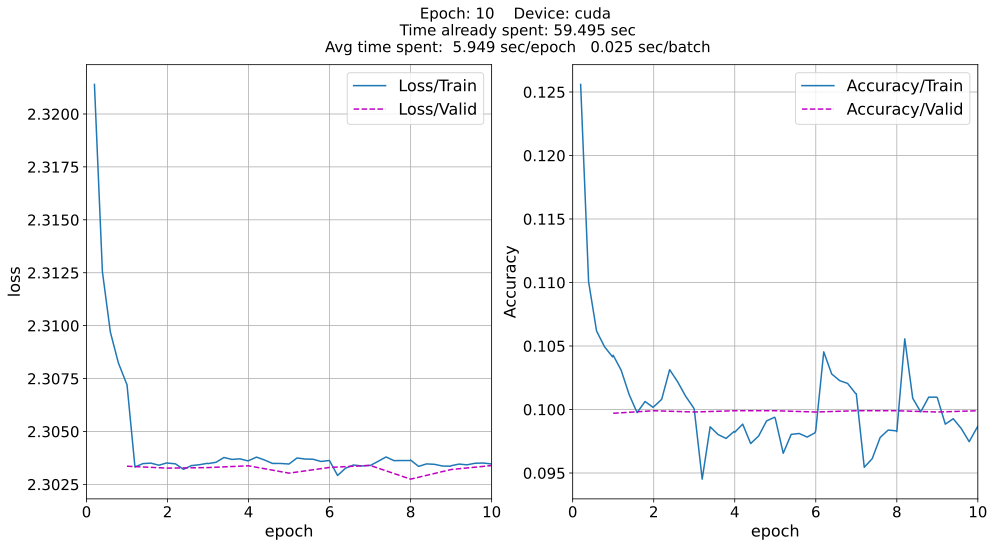

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.9)
train_model(net, train_iter, test_iter, loss_fn, ['accuracy'], optimizer, num_epochs=10, device=device, use_tensorboard=True, use_animator=True, comment='_LeNet_relu_default') 

In [22]:
test_model(net, test_iter, loss_fn, ['accuracy'], device=device)

        Test result
            Number of instances: 10000
            Number of batches: 39
            Avg loss of each batch: 2.303389
            
Accuracy: 0.100
Time spent: 0.21889758110046387 sec
                45683.465 examples/sec
                0.006 sec/batch on cuda
                


(2.303388693393805, [0.0999])

## 改小学习率试试

Train result
loss 2.298
final train Accuracy 0.203
final valid Accuracy 0.206
6356.277 examples/sec on cuda
9.424 sec/epoch on cuda


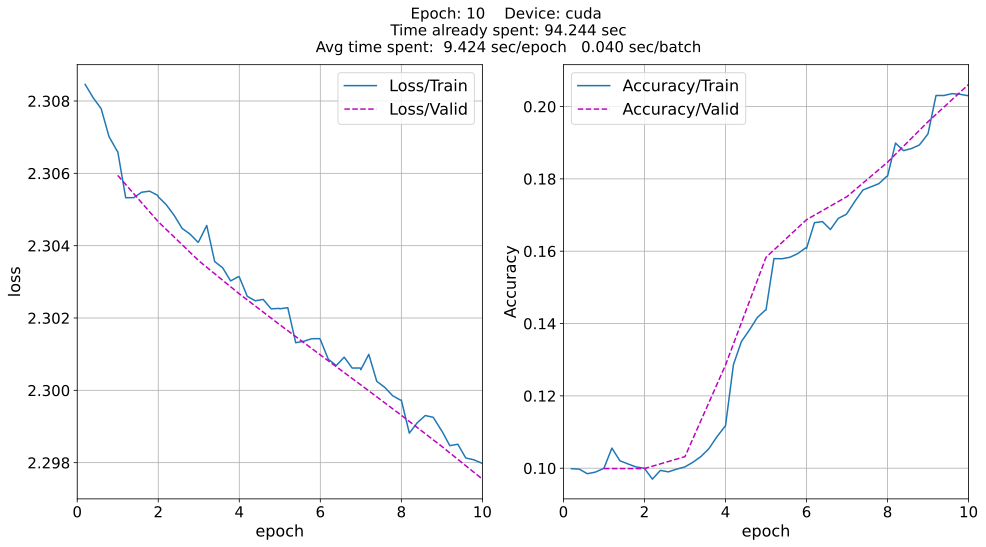

In [23]:
net = LeNet_ReLU()
print(net)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
train_model(net, train_iter, test_iter, loss_fn, ['accuracy'], optimizer, num_epochs=10,
            device=device, use_tensorboard=True, use_animator=True, comment='_LeNet_relu_default_lr0.001')

In [24]:
test_model(net, test_iter, loss_fn, ['accuracy'], device=device)


        Test result
            Number of instances: 10000
            Number of batches: 39
            Avg loss of each batch: 2.297545
            
Accuracy: 0.206
Time spent: 0.19503378868103027 sec
                51273.167 examples/sec
                0.005 sec/batch on cuda
                


(2.29754463220254, [0.2061])

Train result
loss 0.699
final train Accuracy 0.733
final valid Accuracy 0.729
4092.093 examples/sec on cuda
14.639 sec/epoch on cuda


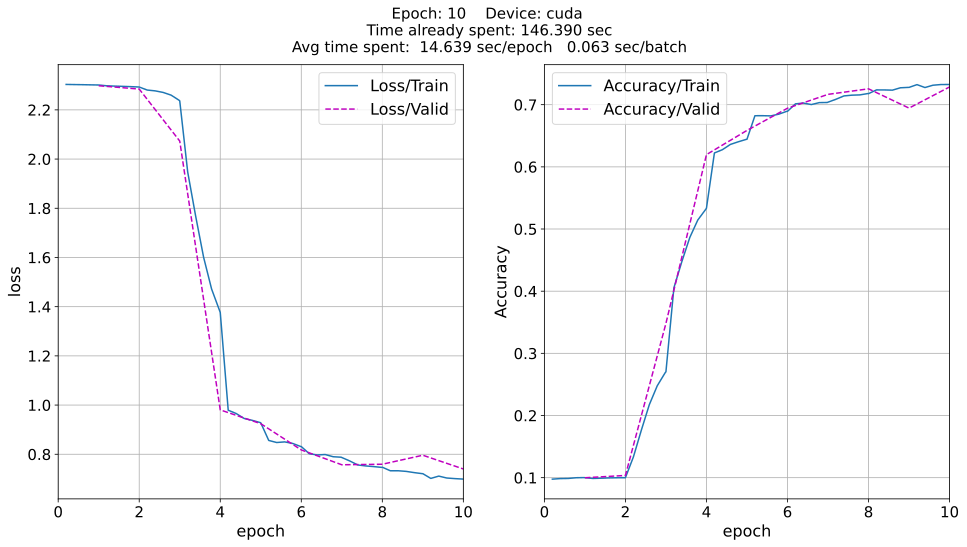

In [26]:
net = LeNet_ReLU()
print(net)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
train_model(net, train_iter, test_iter, loss_fn, ['accuracy'], optimizer, num_epochs=10,
            device=device, use_tensorboard=True, use_animator=True, comment='_LeNet_relu_default_lr0.01')


In [27]:
test_model(net, test_iter, loss_fn, ['accuracy'], device=device)

        Test result
            Number of instances: 10000
            Number of batches: 39
            Avg loss of each batch: 0.740165
            
Accuracy: 0.729
Time spent: 0.5038166046142578 sec
                19848.492 examples/sec
                0.013 sec/batch on cuda
                


(0.740164733850039, [0.7285])

## 试试Adam

Train result
loss 0.232
final train Accuracy 0.913
final valid Accuracy 0.897
8750.765 examples/sec on cuda
6.846 sec/epoch on cuda


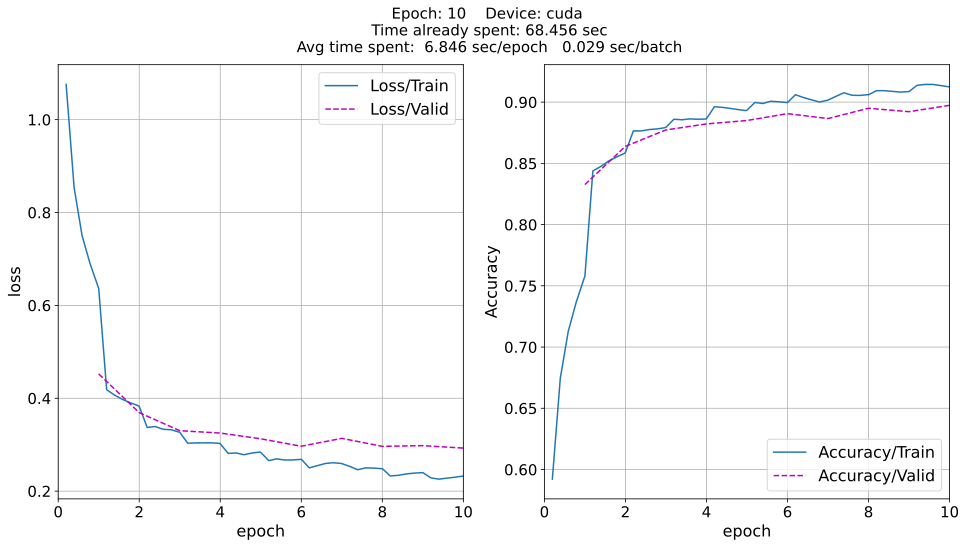

In [28]:
net = LeNet_ReLU()
print(net)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
train_model(net, train_iter, test_iter, loss_fn, ['accuracy'], optimizer, num_epochs=10,
            device=device, use_tensorboard=True, use_animator=True, comment='_LeNet_relu_default_lr0.01_Adam')

In [29]:
test_model(net, test_iter, loss_fn, ['accuracy'], device=device)

        Test result
            Number of instances: 10000
            Number of batches: 39
            Avg loss of each batch: 0.292663
            
Accuracy: 0.897
Time spent: 0.20128345489501953 sec
                49681.182 examples/sec
                0.005 sec/batch on cuda
                


(0.2926630614659725, [0.8974])

## 加Batch Normalization

Train result
loss 0.282
final train Accuracy 0.903
final valid Accuracy 0.889
6242.342 examples/sec on cuda
9.596 sec/epoch on cuda


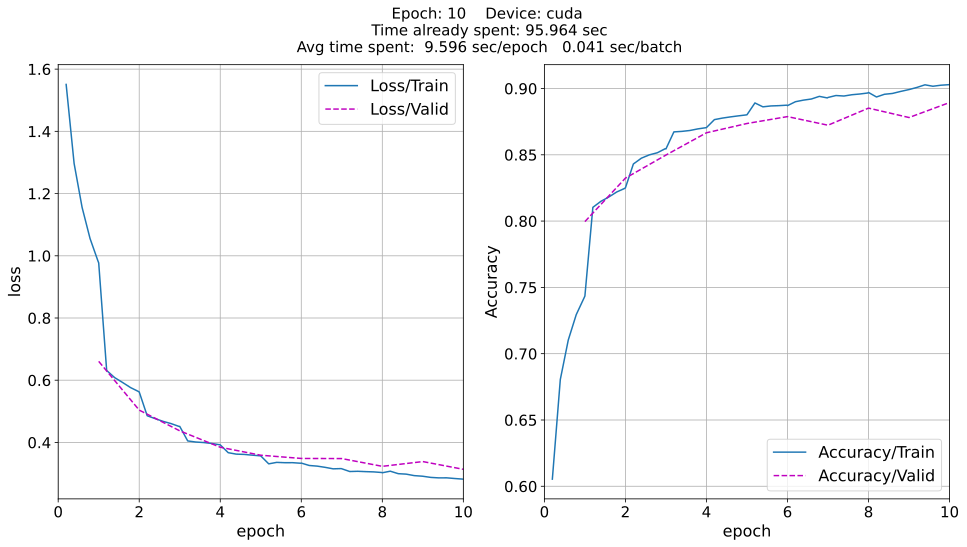

In [30]:
class LeNet_ReLU_BN(nn.Module):
    def __init__(self, *args, **kwargs):
        super(LeNet_ReLU_BN, self).__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.avgpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x

net = LeNet_ReLU_BN()
print(net)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
train_model(net, train_iter, test_iter, loss_fn, ['accuracy'], optimizer, num_epochs=10,
            device=device, use_tensorboard=True, use_animator=True, comment='_LeNet_relu_default_lr0.001_SGD_BN')


In [31]:
test_model(net, test_iter, loss_fn, ['accuracy'], device=device)

        Test result
            Number of instances: 10000
            Number of batches: 39
            Avg loss of each batch: 0.313639
            
Accuracy: 0.889
Time spent: 0.23833513259887695 sec
                41957.725 examples/sec
                0.006 sec/batch on cuda
                


(0.3136393481340164, [0.8894])

## BN+ReLU+Adam

Train result
loss 0.168
final train Accuracy 0.936
final valid Accuracy 0.899
6359.772 examples/sec on cuda
9.419 sec/epoch on cuda


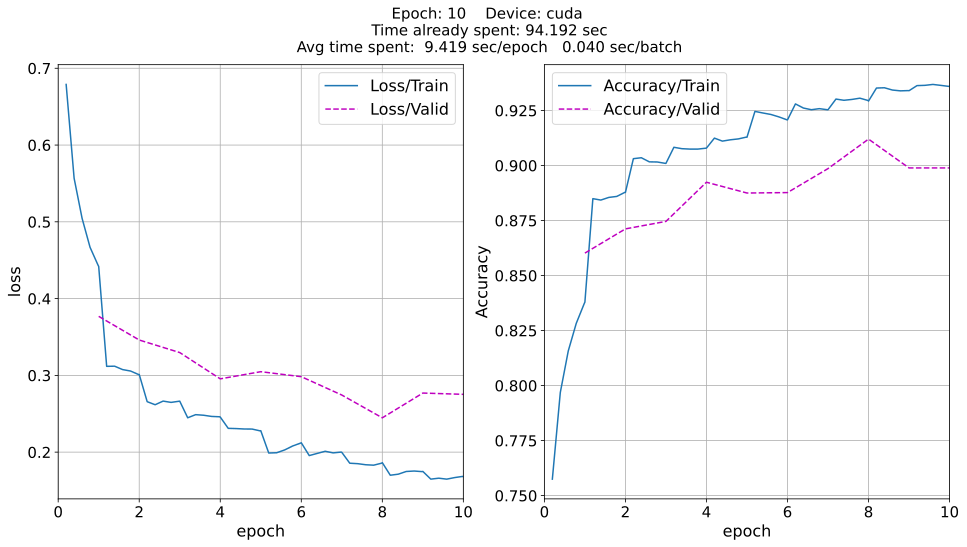

In [32]:
class LeNet_ReLU_BN(nn.Module):
    def __init__(self, *args, **kwargs):
        super(LeNet_ReLU_BN, self).__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.avgpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x


net = LeNet_ReLU_BN()
print(net)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
train_model(net, train_iter, test_iter, loss_fn, ['accuracy'], optimizer, num_epochs=10,
            device=device, use_tensorboard=True, use_animator=True, comment='_LeNet_relu_default_lr0.001_Adam_BN')

In [33]:
test_model(net, test_iter, loss_fn, ['accuracy'], device=device)

        Test result
            Number of instances: 10000
            Number of batches: 39
            Avg loss of each batch: 0.275314
            
Accuracy: 0.899
Time spent: 0.30840182304382324 sec
                32425.230 examples/sec
                0.008 sec/batch on cuda
                


(0.27531397839387256, [0.8989])